In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import theano
floatX = theano.config.floatX
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as T

%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import scale
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
""" This section extracts and cleans all the data in the .data file  """

def extraction(pathname):
    initial = open(pathname)
    
    image_data = []
    for line in initial:
        image_data.append(line.strip()) #Extracting data line by line
        
    final_data = []
    target = []
    
    # Each line is a record that contains the attributes, delimited by a comma
    
    for string in image_data: 
    
        string2 = list(string)
    
        bad_data = False
    
        indexes = [-1]
    
        for (index,element) in enumerate(string2):
            if element == ',':
                indexes.append(index) # Finding the indexes where the string needs to be be cut
                
        indexes.append(len(string))
        data = [] 
    
        for i in range(1,len(indexes)):
            # For each split by a comma, we extract the element
            element = string[indexes[i-1]+1:indexes[i]]
        
            try:
            # If the data is float, we extract it
                element = float(element)
                data.append(element)
        
            except:
            # Otherwise it's bad data.
            # This includes inputs like missing data, 'NA' or 'nan'
                bad_data = True
        
        if not bad_data:
            final_data.append(data[1:len(data)-1])
            target.append(data[-1])
            # Appending the data and the class to the data list and target list
    
    return np.array(final_data), np.array(target).reshape(len(target))

In [3]:
""" Running the algorithm above on the downloaded file """

dataset, target = extraction('breast-cancer-wisconsin.data')

In [4]:
columns = ['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 
           'Compactness', 'Concavity', 'Concave Points', 'Symmetry']

In [5]:
data_df = pd.DataFrame(dataset, columns=columns)

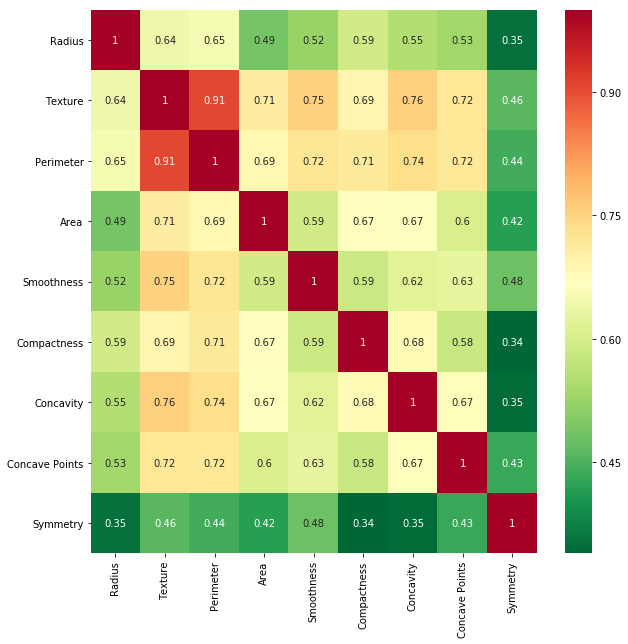

In [6]:
import seaborn as sns

correlation_matrix = data_df.corr()
plt.figure(figsize=(10,10))
g=sns.heatmap(correlation_matrix,annot=True,cmap="RdYlGn_r")

In [7]:
data = pd.read_csv('final_data.csv') # Uploading a processed version

In [8]:
data.head()

,Index,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concave Points,Symmetry,Target
0,0,0.197905,-0.702212,-0.741774,-0.639366,-0.555608,-0.698853,-0.612927,-0.3484,0
1,1,0.197905,0.277252,0.262783,0.758032,1.695166,1.772867,-0.285105,-0.3484,0
2,2,-0.511643,-0.702212,-0.741774,-0.639366,-0.555608,-0.424217,-0.612927,-0.3484,0
3,3,0.552679,1.583204,1.602192,-0.639366,-0.105454,0.125054,1.354008,-0.3484,0
4,4,-0.156869,-0.702212,-0.741774,0.059333,-0.555608,-0.698853,-0.612927,-0.3484,0


In [9]:
x_columns = list(data.columns)
x_columns.remove('Index')
x_columns.remove('Target')

In [10]:
X = data[x_columns].values
Y = data['Target'].values

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA()
X = pca.fit_transform(X)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

In [13]:
import numpy as np
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import seaborn as sns; sns.set()

# Neural Net Python Class

In [14]:
class advi_neural_network():
    def __init__(self):
        self.neural_network = None
        self.inference = None
        self.approx = None
        self.false_negative_num = []
        self.false_positive_num = []
        self.total_errors = []
        
    def build_network(self, X_train, Y_train):

        # We're initialising the weights here (the parameters we need to optimise)
        # Note that the shape of the distribution should match the dimension of the layer.
        # So, first distribution should go from X.shape[1] = 9 to 8 and so forth.
        initial_weights_1 = np.random.randn(X.shape[1], 8).astype(floatX)
        initial_weights_2 = np.random.randn(8, 7).astype(floatX)
        initial_weights_p = np.random.randn(7).astype(floatX)

        # Initialising a model
        with pm.Model() as self.neural_network:
            features = pm.Data('ann_input', X_train) # Denoting input data
            output = pm.Data('ann_output', Y_train) # Denoting targets

            # We're now taking the set of parameters and assigning a prior distribution to them.
            # The pm.Normal assigns a Normal distribution with mean 0 and standard deviation 1

            prior_1 = pm.Normal('w_in_1', 
                                0 ,  #mean
                                sigma=1, # standard deviation
                                shape=(X.shape[1], 8), # shape of set of parameters
                                testval=initial_weights_1) # initialised parameters

            prior_2 = pm.Normal('w_1_2', 0, sigma=1, shape=(8, 7), testval=initial_weights_2)
            prior_perceptron = pm.Normal('w_2_out', 0, sigma=1, shape=(7,), testval=initial_weights_p)

            # Now, we'll assign the functional form of each layer
            # tanh for the first three and sigmoid for the perceptron
            layer_1 = pm.math.tanh(pm.math.dot(features, prior_1))
            layer_2 = pm.math.tanh(pm.math.dot(layer_1, prior_2))
            perceptron = pm.math.sigmoid(pm.math.dot(layer_2, prior_perceptron))

            # A bernoulli distribution as the likelihood helps model the 0,1 data as pass/fails
            likelihood = pm.Bernoulli('out', perceptron, observed=Y_train, total_size=Y.shape[0])
                
    def fit(self):
        from pymc3.variational.callbacks import CheckParametersConvergence
        from pymc3.theanof import set_tt_rng, MRG_RandomStreams
        
        set_tt_rng(MRG_RandomStreams(42))
        
        with self.neural_network:
            self.inference = pm.ADVI()
            self.approx = pm.fit(n=30000, method=self.inference, callbacks=[CheckParametersConvergence()])
    
    def plot_advi(self):
        plt.figure(figsize=(12,6))
        plt.plot(-self.inference.hist, label='new ADVI', alpha=.75)
        plt.plot(self.approx.hist, label='old ADVI', alpha=.75)
        plt.legend(fontsize=15)
        plt.ylabel('ELBO', fontsize=15)
        plt.xlabel('Iterations', fontsize=15)
        plt.show()
        
        
    def traceplot(self):
        self.trace = self.approx.sample(draws=5000)
        pm.traceplot(self.trace)
    
    def plot_disssected_weights(self, parameters = ['w_in_1', 'w_1_2']):
        self.means = self.approx.bij.rmap(self.approx.mean.eval())
        self.sds = self.approx.bij.rmap(self.approx.std.eval())
        
        from scipy import stats

        for parameter in parameters:
            w_1_m = self.means[parameter] 
            w_1_s = self.sds[parameter]

            fig, axs = plt.subplots(nrows=8, figsize=(15, 30))
            for var, ax in zip(range(8), axs):
                mu_arr = w_1_m[var]
                sigma_arr = w_1_s[var]

                ax.set_title('Distribution of weights from Feature {} for {}'.format(var+1, parameter), 
                             fontsize=15)
                for i, (mu, sigma) in enumerate(zip(mu_arr.flatten(), sigma_arr.flatten())):
                    sd3 = (-4*sigma + mu, 4*sigma + mu)
                    x = np.linspace(sd3[0], sd3[1], 300)
                    y = stats.norm(mu, sigma).pdf(x)
                    ax.plot(x, y)
            fig.tight_layout()
            plt.show()
            
    
    def sample_probabilities(self):
        x = T.matrix('X') # create symbolic input
        n = T.iscalar('n') # number of samples
        x.tag.test_value = np.empty_like(X_train[:10]) #initialising test values
        n.tag.test_value = 100

        # We now have to generate samples from our nodes 
        # that'll help us make the test predictions
        _sample_proba = self.approx.sample_node(self.neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={self.neural_network['ann_input']: x})

        # Converting the samples into a workable function
        self.sample_proba = theano.function([x, n], _sample_proba)
        
    def predict_probabilities(self, decision_boundary):
        return self.sample_proba(X_test, 500).mean(0) > decision_boundary
    
    def accuracy(self,decision_boundary):
        pred = self.predict_probabilities(decision_boundary)
        correct = 0
        
        for i in range(len(pred)):
            if pred[i] == Y_test[i]:
                correct += 1
                
        return correct*100/len(pred)
            
    
    def plot_errors(self):
        
        def false_negatives(pred):
            false_neg = 0
            false_pos = 0
    
            for i in range(len(pred)):
                if pred[i] == 0 and list(Y_test)[i] == 1:
                    false_neg+=1
                elif pred[i] == 1 and list(Y_test)[i] == 0:
                    false_pos+=1

            return false_neg, false_pos
        
        boundaries = np.linspace(0,1,101)
        false_negative_num = []
        false_positive_num = []
        total_errors = []

        for i in boundaries:
            pred = self.predict_probabilities(i)
            n, p = false_negatives(pred)
            false_negative_num.append(n*100/len(pred))
            total_errors.append((n+p)*100/len(pred))
            false_positive_num.append(p*100/len(pred))
            
        plt.figure(figsize=(20,10))
        plt.plot(boundaries, false_negative_num, label='False Negative Rate(%)', color='red')
        plt.plot(boundaries, false_positive_num, label='False Positive Rate(%)')
        plt.plot(boundaries, total_errors, label='Total Error Rate(%)', color='orange')
        plt.xlabel('Decision Boundary', fontsize=20)
        plt.ylabel('Percentage Cases', fontsize=20)
        plt.legend(fontsize=20)
        plt.show()

### Initialising the network

In [15]:
our_network = advi_neural_network()
our_network.build_network(X_train, Y_train)

### Optimization

Average Loss = 57.516: 100%|██████████| 30000/30000 [00:20<00:00, 1478.42it/s]
Finished [100%]: Average Loss = 57.554


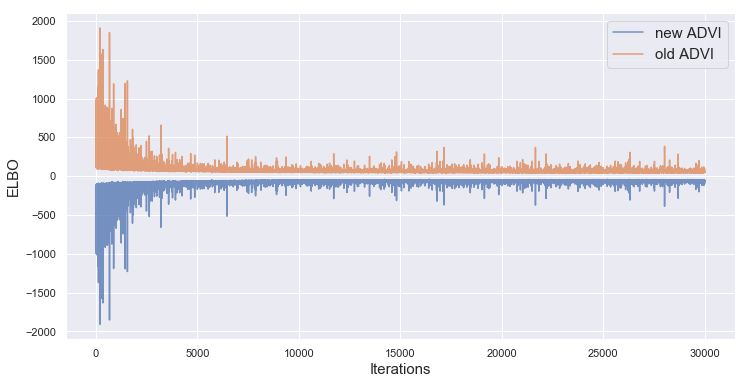

In [16]:
our_network.fit()
our_network.plot_advi()

### TracePlot

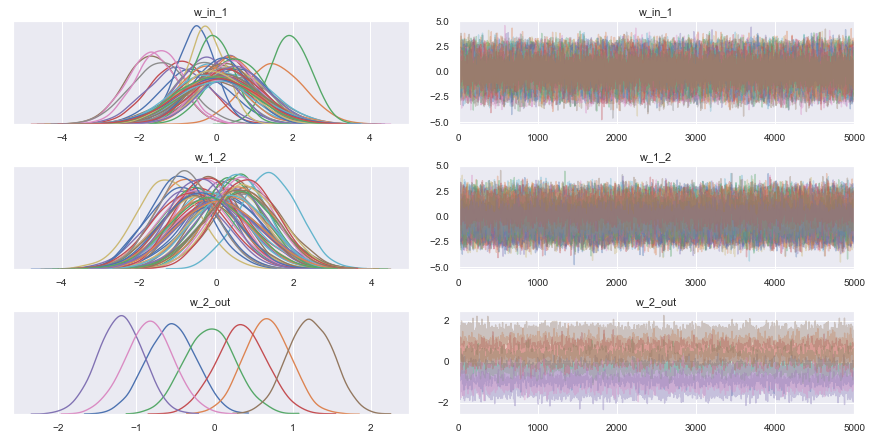

In [17]:
our_network.traceplot()

### Plotting weights separately

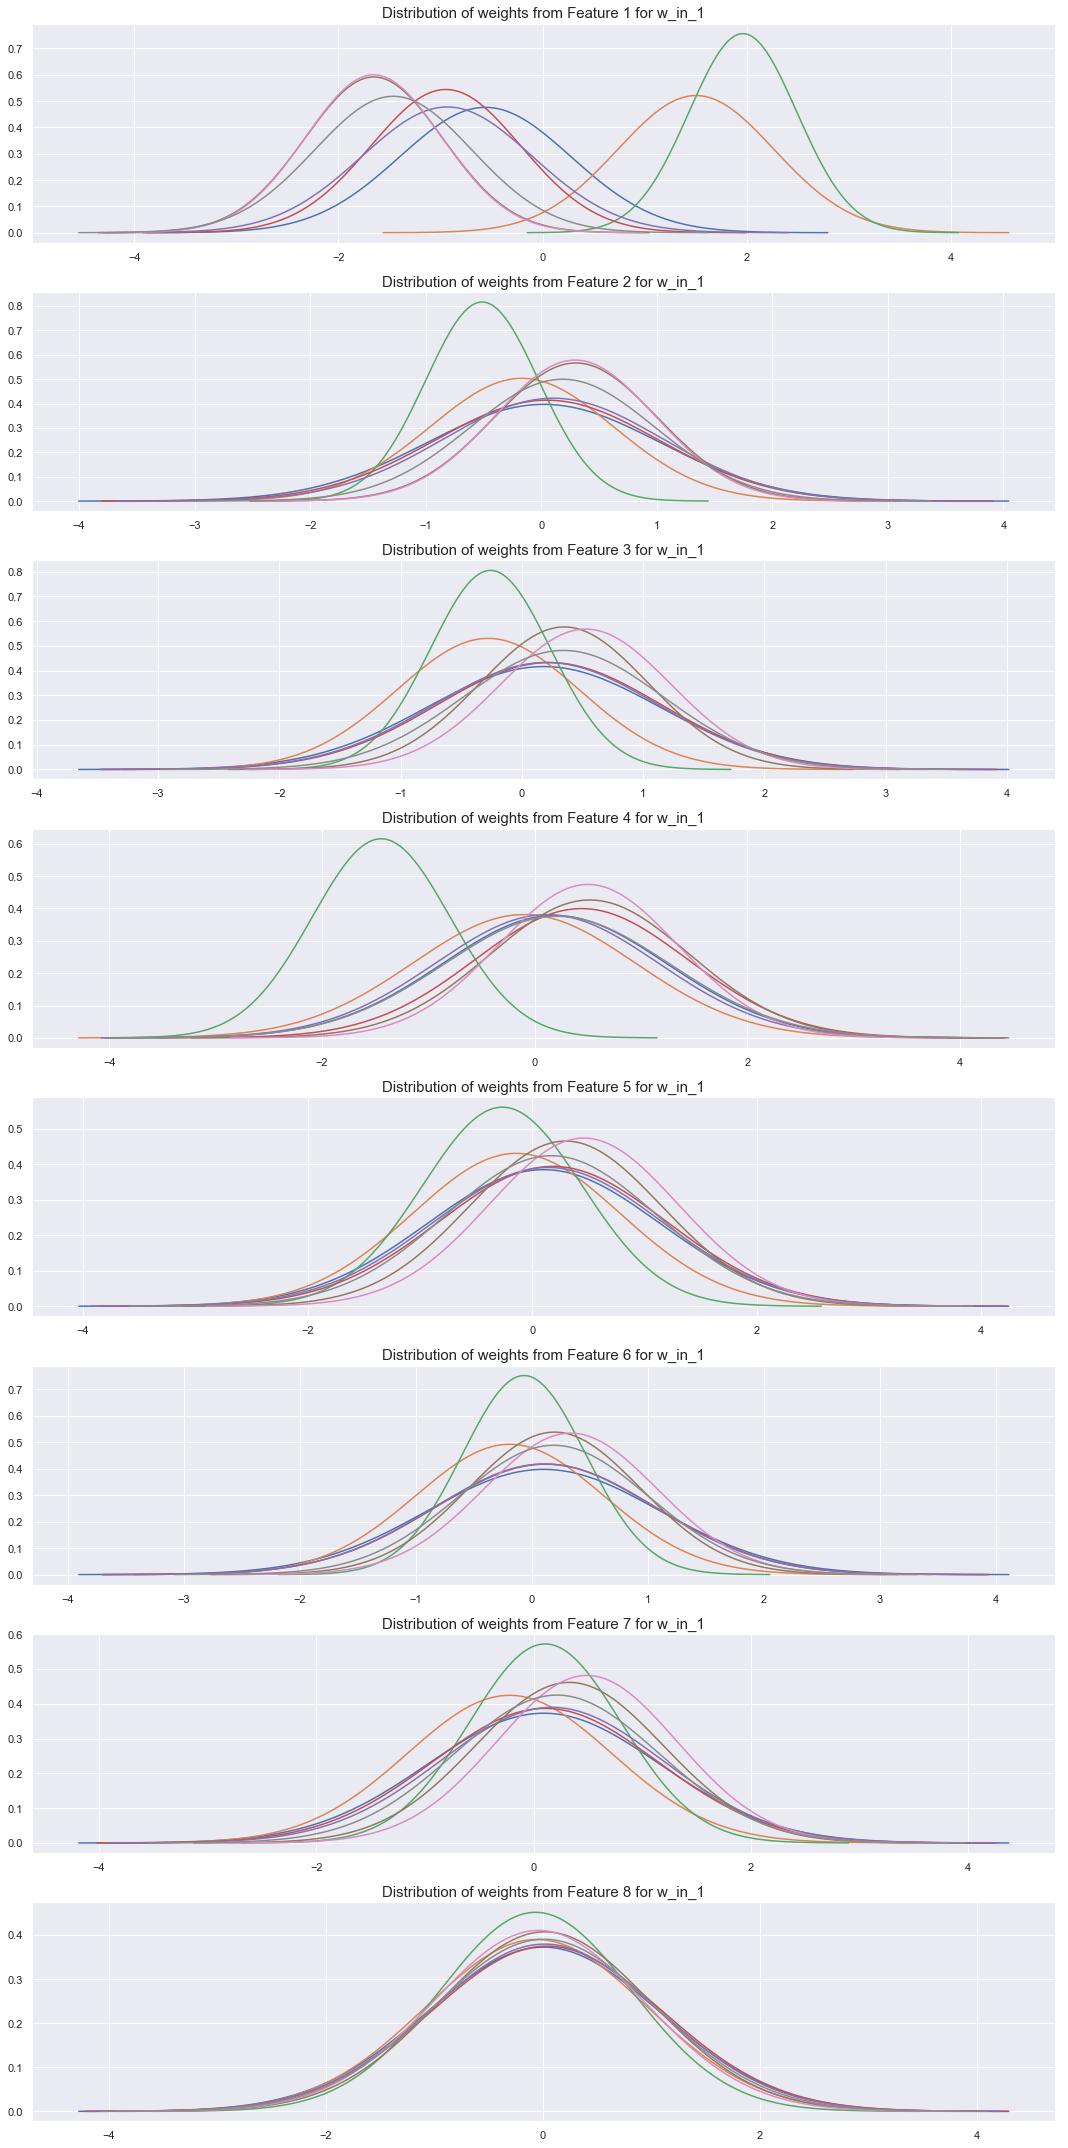

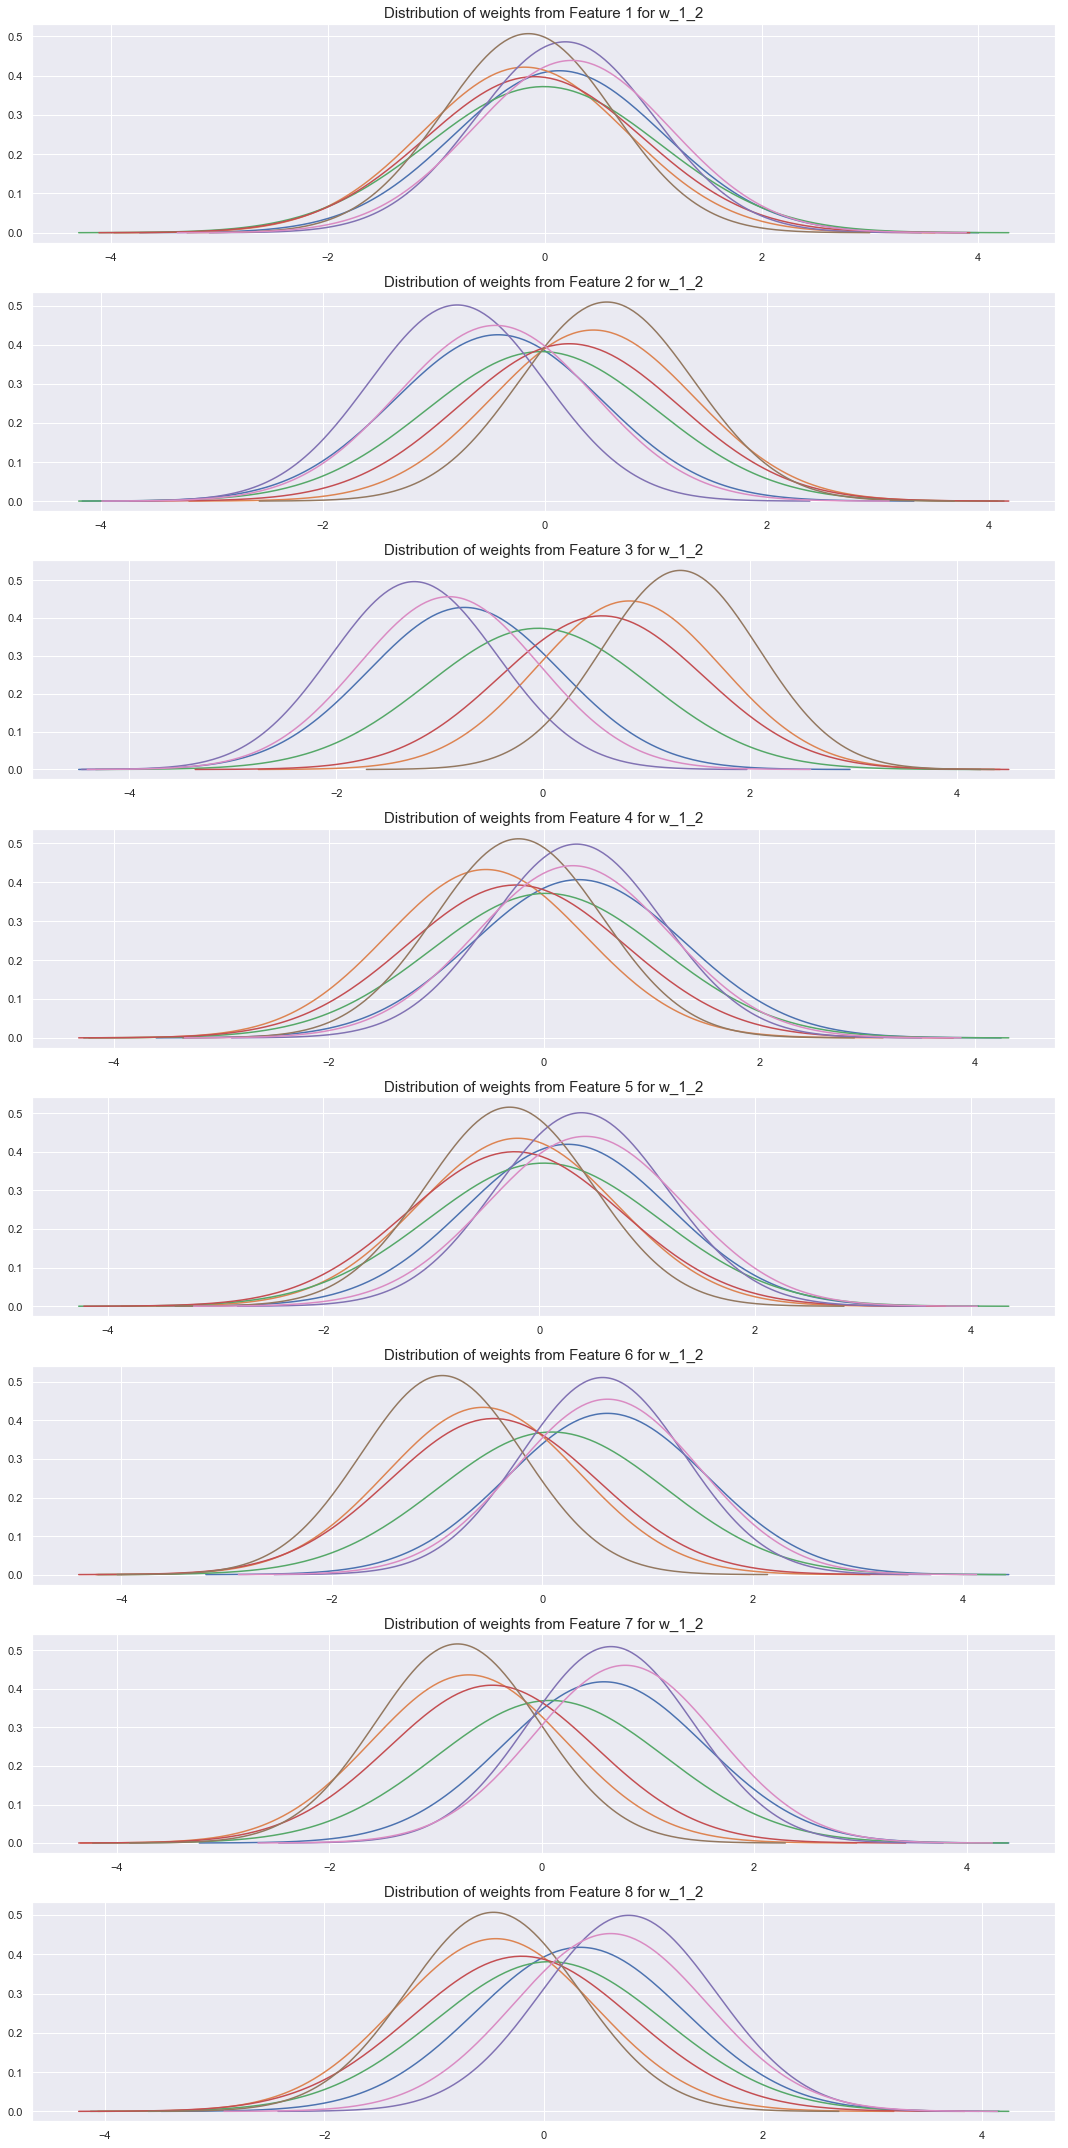

In [18]:
our_network.plot_disssected_weights()

### Plotting weights

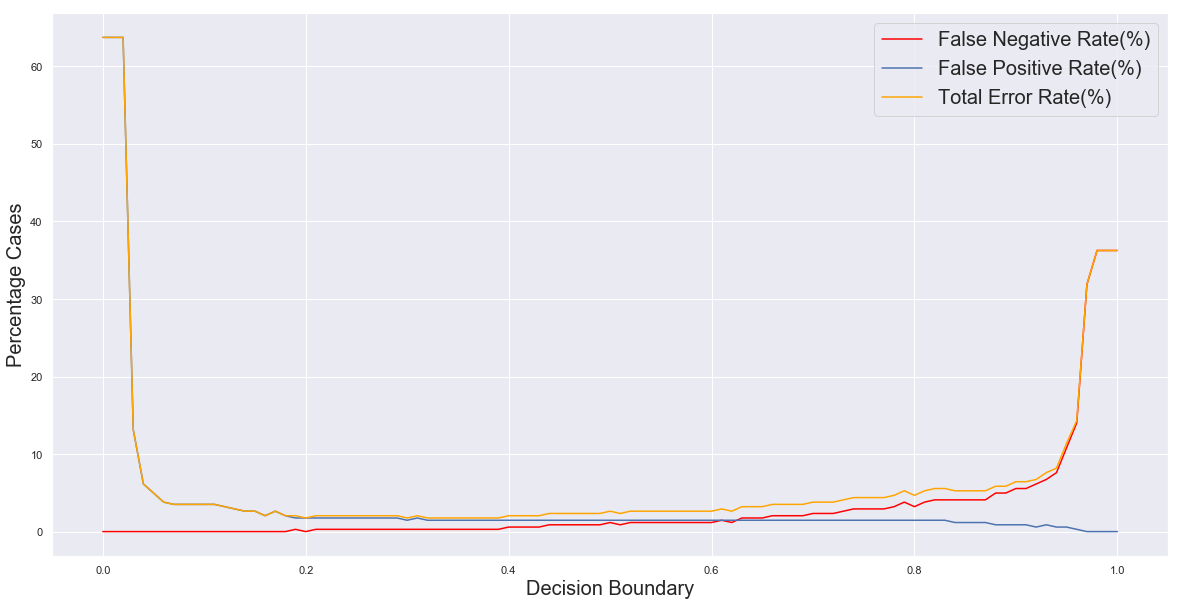

In [19]:
our_network.sample_probabilities()
our_network.plot_errors()

In [20]:
our_network.accuracy(0.4)

98.24561403508773